<div style="display: flex; justify-content: space-between; align-items: flex-start; margin: 0px 0px 5px 0px;">
    <div style="text-align: left;">
        <img src="https://upload.wikimedia.org/wikipedia/commons/b/b6/HULT_IBS_Logo_Outline_Black_%28cropped%29.png" width="150" style="margin: 10px 0px 5px 0px;"/>
        <div style="margin: 0px 0px 0px 0px;">
            <span style="color: #808080;"><b>Program:</b> MBAN DD<br></span>
            <span style="color: #808080;"><b>Professor:</b> Luis Escamilla<br></span>
            <span style="color: #808080;"><b>Date:</b> 20 December 2023<br></span>
        </div>
    </div>
    
<div style="float: right; margin: 10px 15px 15px 50px; text-align: center;">
        <a href="https://www.linkedin.com/in/surajudasi/" target="_blank" style="color: #2B547E;">
            <img src="https://media.licdn.com/dms/image/D4E03AQFQYxwabge-wA/profile-displayphoto-shrink_400_400/0/1698184459749?e=1713398400&v=beta&t=fcUb7V9C3GWKl76YvQDj9KJCRW4IcmXIGKERGPutWOU" style="border: 5px solid #2B547E; border-radius: 40%; width: 150px;">
        </a>
        <br>
        <b style="color: #2B547E; display: block;">Suraj Udasi</b>
</div>

    
<div style="text-align: right; margin: 50px 15px 15px 50px;">
    <b style="font-size: 20px; color: #808080;">Retiree Income Projection </b><br>
    <em style="color: #808080;"><strong>Business Challenge 1</strong></em><br><br>
 </div>


In [1]:
# Standard library imports
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick 
from matplotlib import style


# Set global configurations
warnings.filterwarnings("ignore")  
np.random.seed(42)  # Ensure reproducibility

# Loading Real Data for Calculations from CSVs

In [2]:
# Load Real Tax, Inflation and RMD data
def read_csv_and_copy(data_path, filename):
    # Construct the full file path
    file_path = data_path + filename
    
    # Read the CSV file into a DataFrame
    df_data = pd.read_csv(file_path)
    
    # Create a copy of the DataFrame for analysis
    df = df_data.copy()
    
    return df

# Reading CSVs
data_path = "./data/"
caltax_filename = "Current California State Rates.csv"
california_tax_brackets = read_csv_and_copy(data_path, caltax_filename)

fedtax_filename = "Current Federal Tax Rates.csv"
federal_tax_brackets = read_csv_and_copy(data_path, fedtax_filename)

masstax_filename = "Current Massachusetts Personal Income Tax.csv"
massachusetts_tax_brackets = read_csv_and_copy(data_path, masstax_filename)

inflation_filename = "Projected Inflation.csv"
inflation_data = read_csv_and_copy(data_path, inflation_filename)

rmd_filename = "RMD Life Expectancy Factor.csv"
rmd_table = read_csv_and_copy(data_path, rmd_filename)


# Defining Functions

In [3]:
# Validation Function for User Inputs
def get_float_input(prompt):
    while True:
        try:
            return float(input(prompt))
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

def get_int_input(prompt):
    while True:
        try:
            return int(input(prompt))
        except ValueError:
            print("Invalid input. Please enter an integer.")

            
def validate_state_input(state):
    valid_states = ['CA', 'MA', 'ca', 'ma', 'Ca', 'Ma']
    while state not in valid_states:
        print(f"Invalid state. Please enter one of the following: {valid_states}")
        state = input("Enter your state ('CA'/'MA'): ")
    return state            
            
# Function to get User Inputs            
def get_user_inputs():
    """
    Gets and validates user inputs for the retirement planning tool.

    Returns:
    dict: A dictionary containing user inputs.
    """
    state_input = input("Enter your state ('CA'/'MA'): ")
    validated_state = validate_state_input(state_input)
    
    inputs = {
        'savings_balance': get_float_input("Enter the initial savings account balance: "),
        'ira_balance': get_float_input("Enter the initial IRA account balance: "),
        'annual_spending_budget': get_float_input("Enter the annual spending budget: "),
        'savings_interest_rate': get_float_input("Enter the annual interest rate for the savings account (%): ") / 100,
        'ira_interest_rate': get_float_input("Enter the annual interest rate for the IRA account (%): ") / 100,
        'current_age': get_int_input("Enter the current age of the retiree: "),
        'state': validated_state,
    }  
    return inputs

# Function to clean tax data
def clean_tax_data(df):
    df['Over'] = df['Over'].replace({',': '', '-': '0'}, regex=True).astype(float)
    df['Up to'] = df['Up to'].replace({',': '', '-': '999999999'}, regex=True).astype(float)
    df['Base Tax'] = df['Base Tax'].replace({'\$': '', ',': '', ' -   ': '0'}, regex=True).astype(float)
    df['% on excess'] = df['% on excess'].replace({'%': ''}, regex=True).astype(float)
    return df

# Functions to calculate federal and state taxes
def calculate_federal_tax(taxable_income, tax_brackets):
    tax_brackets = tax_brackets.sort_values(by='Over')
    tax_due = 0
    for index, row in tax_brackets.iterrows():
        lower_limit = row['Over']
        upper_limit = row['Up to']
        base_tax = row['Base Tax']
        excess_rate = row['% on excess']

        if taxable_income <= lower_limit:
            break
        elif taxable_income <= upper_limit:
            tax_due += base_tax + (taxable_income - lower_limit) * excess_rate/100
            break
        else:
            continue
            
    return tax_due

def calculate_state_tax(taxable_income, state_tax_brackets):
    return calculate_federal_tax(taxable_income, state_tax_brackets)

def calculate_massachusetts_state_tax(taxable_income, flat_tax_rate):
    return taxable_income * flat_tax_rate

# Function to adjust expenses based on inflation rates
def calculate_inflation_adjusted_expenses(initial_expenses, inflation_df, start_year, current_year):
    adjusted_expenses = initial_expenses
    for year in range(start_year, current_year + 1):
        inflation_rate = float(inflation_df.loc[inflation_df['Year'] == year, 'Percentage Change'].values[0].strip('%'))
        adjusted_expenses *= (1 + inflation_rate / 100)
    return adjusted_expenses

# Function to calculate compound interest for one month
def calculate_monthly_compound_interest(balance, annual_interest_rate):
    monthly_interest_rate = annual_interest_rate / 12
    amount_after_interest = balance * (1 + monthly_interest_rate)
    monthly_interest = amount_after_interest - balance
    return monthly_interest

# Withdrawal logic
def handle_monthly_withdrawals(inputs, federal_tax_brackets, state_tax_brackets, rmd_table, current_year, current_month):
    """
    Calculate the monthly withdrawals from savings and IRA accounts.

    Parameters:
    inputs (dict): Dictionary of user inputs and financial information.
    tax_brackets (tuple): Federal and state tax information.
    rmd_table (DataFrame): RMD life expectancy table.
    date_year_month (input): current year and month.

    Returns:
    dict: Updated account balances and other financial information after withdrawal.
    """
    # Declaring global variables to store rolling data
    global current_year_taxable_income  
    global last_year_taxable_income
    global yearly_withdrawal_ira
    global account_balance_ira_january
    
    savings_balance = inputs['savings_balance']
    ira_balance = inputs['ira_balance']
    monthly_spending = inputs['monthly_spending']
    monthly_taxable_income = 0
    rmd_amount = 0
    age = inputs['current_age'] + (current_year - 2023)
    state = inputs['state']
    
    # Reset global variables in January
    if current_month == 1:  
        current_year_taxable_income = 0
        yearly_withdrawal_ira = 0
        account_balance_ira_january = ira_balance  # Calculate RMD based on IRA balance as of Dec.31st of previous year
    
    # Calculate Annual RMD in December
    if age >= 72 and current_month == 12 and age in rmd_table['Age'].values:
        life_expectancy_factor = rmd_table[rmd_table['Age'] == age+1]['Life Expectancy Factor'].values[0] # Adjusting for turning 1 year older within a calendar year
        rmd_amount = account_balance_ira_january / life_expectancy_factor

    total_withdrawal_needed = monthly_spending 

    # Calculating last year taxes to be paid in April
    if current_month == 4:  
        federal_tax = calculate_federal_tax(last_year_taxable_income, federal_tax_brackets_cleaned)
        if state.upper() == 'CA':
            state_tax = calculate_state_tax(last_year_taxable_income, california_tax_brackets_cleaned)
        elif state.upper() == 'MA':
            state_tax = calculate_massachusetts_state_tax(last_year_taxable_income, massachusetts_flat_tax_rate)
        total_tax = federal_tax + state_tax
        total_withdrawal_needed += total_tax 

    # Calculating Monthly Withdrawals from Savings and IRA Account 
    withdraw_from_savings = min(savings_balance, total_withdrawal_needed)
    withdraw_from_ira = max(0, total_withdrawal_needed - withdraw_from_savings)
    withdraw_from_ira = max(withdraw_from_ira, rmd_amount-yearly_withdrawal_ira)
    savings_balance += (withdraw_from_ira - (total_withdrawal_needed-withdraw_from_savings))

    yearly_withdrawal_ira += withdraw_from_ira
    
    # Calculating Interest Earned on Savings and IRA Account
    savings_interest = calculate_monthly_compound_interest(savings_balance-withdraw_from_savings, inputs['savings_interest_rate'])
    ira_interest = calculate_monthly_compound_interest(ira_balance-withdraw_from_ira, inputs['ira_interest_rate'])
    
    # Update taxable income for the current calendar year
    monthly_taxable_income += savings_interest
    monthly_taxable_income += withdraw_from_ira
    current_year_taxable_income += monthly_taxable_income
    
    # Determine if it's December to store last year's taxable income
    if current_month == 12:  
        last_year_taxable_income = current_year_taxable_income

    # Adjusting Ending Savings and IRA Account Balance
    ending_savings_balance = max(0, savings_balance - withdraw_from_savings + savings_interest)
    ending_ira_balance = max(0, ira_balance - withdraw_from_ira + ira_interest)

    return {
        'year': current_year,
        'month': current_month,
        'beginning_savings_balance': savings_balance,
        'beginning_ira_balance': ira_balance,
        'monthly_spending': monthly_spending,
        'total_withdrawal_needed': total_withdrawal_needed,
        'withdraw_from_savings': withdraw_from_savings,
        'withdraw_from_ira': withdraw_from_ira,
        'savings_interest': savings_interest,
        'ira_interest': ira_interest,
        'taxable_income': monthly_taxable_income,
        'ending_savings_balance': ending_savings_balance,
        'ending_ira_balance': ending_ira_balance,
        'current_year_taxable_income': current_year_taxable_income
    }

# Projection function
def run_projection(inputs, federal_tax_brackets, state_tax_brackets, rmd_table, inflation_data, start_year, end_year):
    """
    Run the retirement projection from start year to end year.

    Parameters:
    inputs (dict): Dictionary of user inputs and financial information.
    federal_tax_brackets: Reads Real Federal Tax Data from CSV. 
    state_tax_brackets: Reads Real State Tax Data from CSV.
    rmd_table: Reads Life Expectancy Factor for RMDs from the Age of 72 from CSV.
    inflation_data: Reads Projected Inflation Rates for the Year from CSV.
    start_year (int): The starting year of the projection.
    end_year (int): The ending year of the projection.

    Returns:
    DataFrame: A DataFrame containing the projection results for each month.
    """
    monthly_results = []
    current_year = start_year
    current_month = 1
    
    while inputs['savings_balance'] > 0 or inputs['ira_balance'] > 0:
        if current_month == 1:
            inputs['monthly_spending'] = calculate_inflation_adjusted_expenses(inputs['annual_spending_budget'], inflation_data, 2023, current_year)/12

        monthly_result = handle_monthly_withdrawals(inputs, federal_tax_brackets, state_tax_brackets, rmd_table, current_year, current_month)
        monthly_results.append(monthly_result)

        inputs['savings_balance'] = monthly_result['ending_savings_balance']
        inputs['ira_balance'] = monthly_result['ending_ira_balance']

        current_month = current_month + 1 if current_month < 12 else 1
        current_year = current_year + 1 if current_month == 1 else current_year

        if current_year > end_year:
            break

    return pd.DataFrame(monthly_results)

# Generating Simulation Results
def generate_summary_report(results_df):
    """
    Generates a summary report from the simulation results.

    Parameters:
    results_df (DataFrame): The DataFrame containing the simulation results.

    Returns:
    None: Prints the summary report.
    """
    if results_df.empty:
        print("No simulation data to summarize.")
        return

    final_year = results_df['year'].iloc[-1]
    final_month = results_df['month'].iloc[-1]
    total_interest_earned = results_df['savings_interest'].sum() + results_df['ira_interest'].sum()

    print("\n=== Retirement Simulation Summary ===")
    if final_year < projection_end_year:
        print("You will run out of money in Year", final_year, "Month", final_month)
    else:
        print("You will not run out of money in the next", projection_end_year - 2023, "years")
    print(f"Total interest earned: ${total_interest_earned:,.0f}")
    
# Visualization of Savings and IRA Account Balances over time    
def plot_account_balances(results_df):
    style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plotting the data
    ax.plot(results_df['year'], results_df['beginning_savings_balance'], label='Savings Balance', color='#007acc', alpha=0.7, linewidth=2.5)
    ax.plot(results_df['year'], results_df['beginning_ira_balance'], label='IRA Balance', color='#cc007a', alpha=0.7, linewidth=2.5)
    
    # Formatting the plot
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Balance ($)', fontsize=12, fontweight='bold')
    ax.set_title('Savings and IRA Account Balances Over Time', fontsize=14, fontweight='bold')
    ax.legend(frameon=True, loc='upper left', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

    formatter = mtick.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)

    ax.set_facecolor('#f4f4f4')

    # Adding annotations
    highlight = results_df['year'].idxmax()
    ax.axvline(x=results_df.at[highlight, 'year'], color='grey', linestyle='--', alpha=0.7)
    ax.annotate((results_df['year'].iloc[-1]), xy=(results_df.at[highlight, 'year'], results_df.at[highlight, 'beginning_savings_balance']), 
                xytext=(results_df.at[highlight, 'year'], results_df.at[highlight, 'beginning_savings_balance'] + 50000),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                horizontalalignment='left', verticalalignment='top')
    plt.show()

# Running the Retirement Planning Tool

Welcome to the Retirement Planning Tool

=== Retirement Simulation Summary ===
You will not run out of money in the next 30 years
Total interest earned: $2,072,189


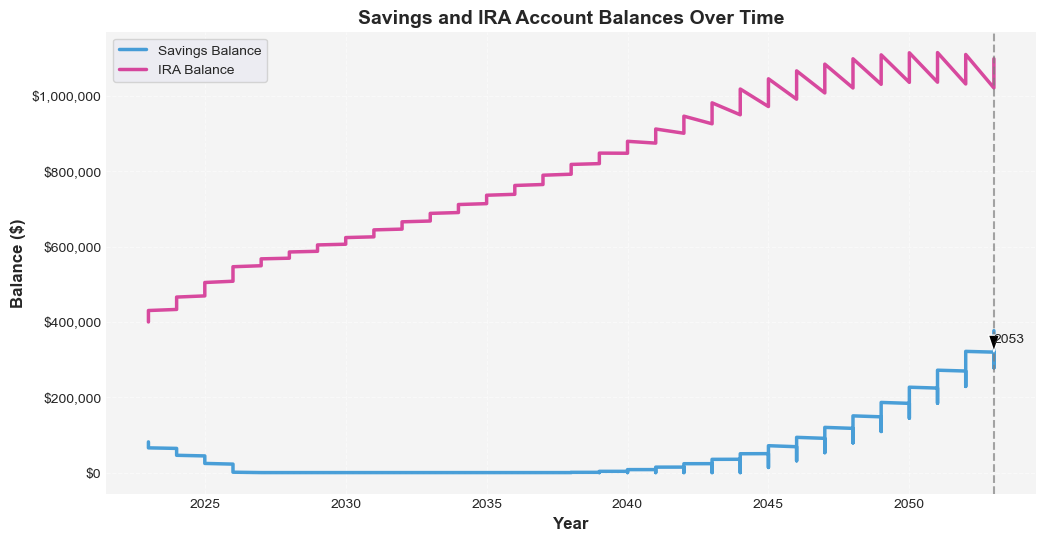

In [4]:
# Running the tool
print("Welcome to the Retirement Planning Tool")

initial_user_input = get_user_inputs() 
user_inputs = initial_user_input.copy()

# Initializing variables
last_year_taxable_income = 0
current_year_taxable_income = 0
yearly_withdrawal_ira = 0
account_balance_ira_january = 0

# Cleaned dataframe with tax brackets
federal_tax_brackets_cleaned = clean_tax_data(federal_tax_brackets)
california_tax_brackets_cleaned = clean_tax_data(california_tax_brackets)
massachusetts_flat_tax_rate = float(massachusetts_tax_brackets.iloc[0, 0].strip('%')) / 100


# Running the projection
projection_end_year = 2053
projection_results = run_projection(user_inputs, federal_tax_brackets_cleaned, california_tax_brackets_cleaned, rmd_table, inflation_data, 2023, projection_end_year)

# Generating Simulation Results
generate_summary_report(projection_results)

# Visualization of Account Balances over time
plot_account_balances(projection_results)


# Creating a subsequent condition for once the loop breaks by giving options to extend their savings by reducing annual expenses
if projection_results['year'].iloc[-1] < projection_end_year:
    print("\nYour savings and IRA accounts ran out in", projection_results['year'].iloc[-1], "Month", projection_results['month'].iloc[-1],". You should consider adjusting your annual spending budget.")
    print("\nWe suggest the following reductions:")
    print("Option 1: Reduction by 15% - Annual Budget:", initial_user_input['annual_spending_budget']*0.85)
    print("Option 2: Reduction by 20% - Annual Budget:", initial_user_input['annual_spending_budget']*0.80)
    print("Option 3: Reduction by 30% - Annual Budget:", initial_user_input['annual_spending_budget']*0.70)
    option = int(input("\nPlease select an option (1,2 or 3):"))
    # Create a new inputs dictionary with adjusted monthly spending
    adjusted_inputs = initial_user_input.copy()
    if option == 1:
        adjusted_inputs['annual_spending_budget'] = initial_user_input['annual_spending_budget']*0.85
    elif option == 2:
        adjusted_inputs['annual_spending_budget'] = initial_user_input['annual_spending_budget']*0.80
    elif option == 3:
        adjusted_inputs['annual_spending_budget'] = initial_user_input['annual_spending_budget']*0.70
    
    # Run the retirement projections again with adjusted expenses
    projection_end_year = 2053  # Adjust the end year
    adjusted_results = run_projection(adjusted_inputs, federal_tax_brackets_cleaned, california_tax_brackets_cleaned, rmd_table, inflation_data, 2023, projection_end_year)

    # Simulation Results
    generate_summary_report(adjusted_results)
    
    # Visualization of Account Balances over time
    plot_account_balances(adjusted_results)
